In [ ]:
import time
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def lvq_fit(train, target, lrate, b, max_epoch):
  label, train_idx = np.unique(target, return_index=True)
  weight = train[train_idx].astype(np.float64)
  train = np.array([e for i, e in enumerate(zip(train, target)) if i not in train_idx])
  train, target = train[:, 0], train[:, 1]
  epoch = 0


  while epoch < max_epoch:
    for i, x in enumerate(train):
      distance = [sum((w - x) ** 2) for w in weight]
      min = np.argmin(distance)
      sign = 1 if target[i] == label[min] else -1
      weight[min] += sign * lrate * (x - weight[min])

    lrate *= b
    epoch += 1

  return (weight, label)

def lvq_fit_with_es(train, target, lrate, b, max_epoch, validation_data=None, patience=10):
    label, train_idx = np.unique(target, return_index=True)
    weight = train[train_idx].astype(np.float64)
    train = np.array([e for i, e in enumerate(zip(train, target)) if i not in train_idx])
    train, target = train[:, 0], train[:, 1]


    if validation_data:
        val_X, val_y = validation_data
        best_val_accuracy = 0
        epochs_without_improvement = 0

    epoch = 0
    while epoch < max_epoch:
        for i, x in enumerate(train):
            distance = [np.sum((w - x) ** 2) for w in weight]
            min_index = np.argmin(distance)
            sign = 1 if target[i] == label[min_index] else -1
            weight[min_index] += sign * lrate * (x - weight[min_index])

        lrate *= b
        epoch += 1


        if validation_data:
            val_predictions = lvq_predict(val_X, (weight, label))
            val_accuracy = np.mean(val_predictions == val_y)

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch} epochs without improvement.")
                break

    return (weight, label)


def lvq_predict(X, model):
  center, label = model
  Y = []
  for x in X:
    d = [sum((c - x) ** 2) for c in center]
    Y.append(label[np.argmin(d)])
  return Y

def train_test_split(X, y, test_size=.1, random_state=32):
    np.random.seed(random_state)
    idx = np.random.permutation(len(X))
    n_test = int(len(X) * test_size)
    idx_test = idx[:n_test]
    idx_train = idx[n_test:]
    X_train = X[idx_train]
    X_test = X[idx_test]
    y_train = y[idx_train]
    y_test = y[idx_test]

    return X_train, X_test, y_train, y_test

def akurasi(y_true, y_pred):
    return sum(y_true == y_pred) / len(y_true)

def pp_biner(df, kolom):
    kamus = {
        value: idx for idx, value in enumerate(df[kolom].unique())
    }

    df[kolom] = df[kolom].map(kamus)
    return df[kolom]

def pp_kategorikal(df, kolom):
    df = pd.get_dummies(df, columns=[kolom], prefix_sep='-', dtype=int)
    return df

def z_score(df, kolom):
    df[kolom] = (df[kolom] - df[kolom].mean()) / df[kolom].std()
    return df[kolom]


In [ ]:
data = pd.read_csv('heart_2.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# cut data heart disease into 400 sample for each classes (1 and 0)
data = data.groupby('HeartDisease').apply(lambda x: x.sample(n=400, random_state=2)).reset_index(drop=True)
data["HeartDisease"].value_counts()

HeartDisease
0    400
1    400
Name: count, dtype: int64

In [ ]:
kolom_obj = data.select_dtypes(include=['object']).columns.tolist()
kolom_numerik = [kolom for kolom in data.columns if kolom not in kolom_obj]
kolom_biner = [kolom for kolom in kolom_obj if len(data[kolom].unique()) == 2]
kolom_kategorikal = [kolom for kolom in kolom_obj if len(data[kolom].unique()) > 2]
kolom_numerik.remove('HeartDisease')

In [ ]:
# preprocessing data biner
for kolom in kolom_biner:
    data[kolom] = pp_biner(data, kolom)

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,45,0,ASY,115,260,0,LVH,185,0,0.0,Up,0
1,41,0,ATA,120,157,0,Normal,182,0,0.0,Up,0
2,36,0,NAP,150,160,0,Normal,172,0,0.0,Up,0
3,55,0,NAP,133,185,0,ST,136,0,0.2,Up,0
4,53,0,ASY,130,182,0,Normal,148,0,0.0,Up,0


In [ ]:
# one hot encoding data kategorikal
for kolom in kolom_kategorikal:
    data = pp_kategorikal(data, kolom)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                800 non-null    int64  
 1   Sex                800 non-null    int64  
 2   RestingBP          800 non-null    int64  
 3   Cholesterol        800 non-null    int64  
 4   FastingBS          800 non-null    int64  
 5   MaxHR              800 non-null    int64  
 6   ExerciseAngina     800 non-null    int64  
 7   Oldpeak            800 non-null    float64
 8   HeartDisease       800 non-null    int64  
 9   ChestPainType-ASY  800 non-null    int32  
 10  ChestPainType-ATA  800 non-null    int32  
 11  ChestPainType-NAP  800 non-null    int32  
 12  ChestPainType-TA   800 non-null    int32  
 13  RestingECG-LVH     800 non-null    int32  
 14  RestingECG-Normal  800 non-null    int32  
 15  RestingECG-ST      800 non-null    int32  
 16  ST_Slope-Down      800 non

In [ ]:
for kolom in kolom_numerik:
    data[kolom] = z_score(data, kolom)

data[kolom_numerik].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,800.0,-1.065814e-16,1.0,-2.661903,-0.757142,0.089418,0.724338,2.523279
RestingBP,800.0,3.819167e-16,1.0,-7.086805,-0.643096,-0.106120,0.430856,3.652711
Cholesterol,800.0,-1.065814e-16,1.0,-1.865697,-0.226203,0.209434,0.626334,3.418158
FastingBS,800.0,-1.065814e-16,1.0,-0.536549,-0.536549,-0.536549,-0.536549,1.861434
MaxHR,800.0,-4.618528e-16,1.0,-3.005226,-0.734124,0.062754,0.779944,2.533076
Oldpeak,800.0,0.000000e+00,1.0,-3.267614,-0.813777,-0.341886,0.601898,5.037680


In [ ]:
from sklearn.metrics import classification_report

X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.9) # tanpa ini 0.875

In [ ]:
start = time.time()
model  = lvq_fit(X_train,y_train, lrate=0.05, b=0.4, max_epoch=1000)
output = lvq_predict(X_test, model)
acc = akurasi(y_test, output)
end_1 = time.time() - start
print(acc)
print(classification_report(y_test, output))
print(f"Time: {end_1} seconds")

0.8611111111111112
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.89      0.77      0.83        31

    accuracy                           0.86        72
   macro avg       0.87      0.85      0.86        72
weighted avg       0.86      0.86      0.86        72

Time: 10.097026348114014 seconds


In [ ]:
start = time.time()
model = lvq_fit_with_es(X_train,y_train, lrate=.05, b=0.4, max_epoch=1000, validation_data=(X_val, y_val), patience=10)
output = lvq_predict(X_test, model)
acc = akurasi(y_test, output)
end_2 = time.time() - start
print(acc)
print(classification_report(y_test, output))
print(f"Time: {end_2} seconds")

Early stopping after 11 epochs without improvement.
0.8611111111111112
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.89      0.77      0.83        31

    accuracy                           0.86        72
   macro avg       0.87      0.85      0.86        72
weighted avg       0.86      0.86      0.86        72

Time: 0.17602825164794922 seconds


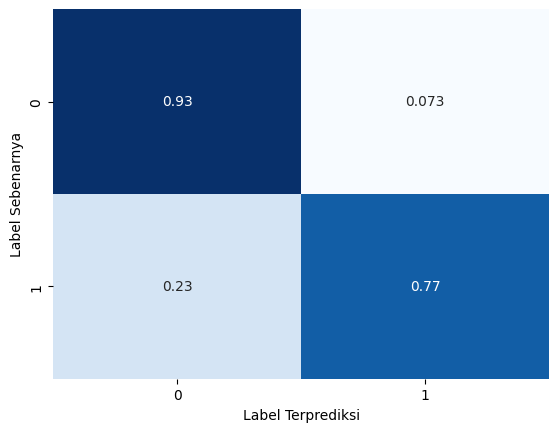

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, output)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
heatmap = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
heatmap.set_xlabel('Label Terprediksi')
heatmap.set_ylabel('Label Sebenarnya')
plt.show()

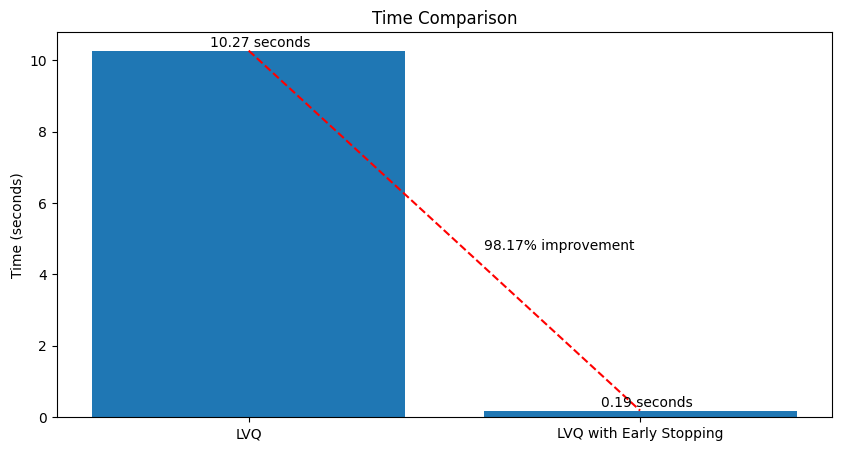

In [ ]:
percent_improvement = (end_1 - end_2) / end_1 * 100

plt.figure(figsize=(10, 5))
plt.bar(['LVQ', 'LVQ with Early Stopping'], [end_1, end_2])
plt.plot([0., 1.], [end_1, end_2], 'r--')  # Add line plot
plt.ylabel('Time (seconds)')
plt.title('Time Comparison')
plt.text(-0.1, end_1 + 0.1, f"{end_1:.2f} seconds")
plt.text(0.9, end_2 + 0.1, f"{end_2:.2f} seconds")
plt.text(0.6, end_2 + 4.5, f"{percent_improvement:.2f}% improvement")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.89      0.77      0.83        31

    accuracy                           0.86        72
   macro avg       0.87      0.85      0.86        72
weighted avg       0.86      0.86      0.86        72



0.2 -> 21
0.1 -> 32